# 5. Viscous flow about a moving body
In this notebook we will demonstrate the simulation of a moving body. It is straightforward
to set up a moving body. The main caveat is that the simulation is considerably slower,
because the integrator must update the operators continuously throughout the simulation.

We will demonstrate this on an oscillating flat plate.

In [1]:
using ViscousFlow

In [2]:
using Plots

### Problem specification and discretization

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

In [4]:
xlim = (-1.0,3.0)
ylim = (-1.0,1.0);
Δx, Δt = setstepsizes(Re,gridRe=4.0)

(0.02, 0.01)

### Set up body
Set up the plate and place it at the origin

In [5]:
body = Plate(1.0,1.0Δx)
T = RigidTransform((0.,0.),0.)
T(body)

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set the body motion
Now we specify the body motion. We will use oscillatory pitch-heave kinematics for this:

In [6]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕp = -π/2  # phase lag of pitch
ϕh = 0.0  # phase lag of heave
A = 0.25  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 10π/180 # amplitude of pitching
U₀ = 0.0 # translational motion (set to zero in place of free stream)
K = π*fstar # reduced frequency, K = πfc/U

oscil1 = RigidBodyTools.PitchHeave(U₀,a,K,ϕp,α₀,Δα,A,ϕh)
motion = RigidBodyMotion(oscil1)

Rigid Body Motion:
  ċ = 0.0 + 0.25im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Oscillatory kinematics with
     Steady velocity U = (0.0,0.0)
     Ref angle α₀ = -1.5707963267948966
     Mean rotation rate α̇₀ = 0.0
     Pitch axis (rel. to centroid) a = (0.25,0.0)
     Frequency Ω = 1.0
     x amplitude Ax, phase lag ϕx = (0.0, 0.0)
     y amplitude Ay, phase lag ϕy = (0.25, 0.0)
     α amplitude Δα, phase lag ϕα = (0.0, 0.17453292519943295)


We can inspect the kinematics in this `motion` by plotting them:

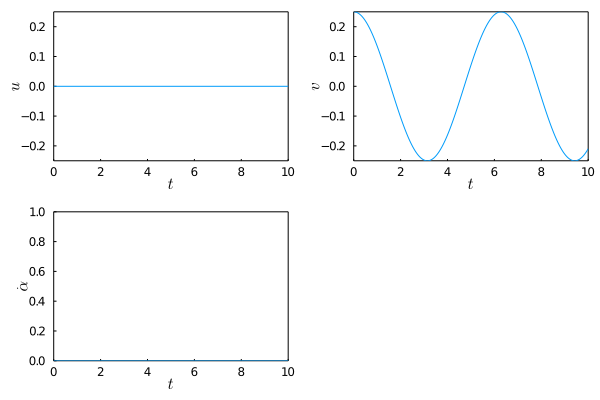

In [7]:
plot(motion)

### Construct the system structure
Here, we supply the motion as an another argument.

In [8]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,body,motion,freestream = U∞)

External flow Navier-Stokes system on a grid of size 208 x 104 and 50 moving immersed points
   Static freestream = (1.0, 0.0)
   1 body


In [9]:
u0 = newstate(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 208, ny = 104) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 104), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve
This takes longer than it does for stationary bodies. Here, we only run it
for a little while just to demonstrate it.

In [10]:
step!(integrator,0.1)

### Examine the solution

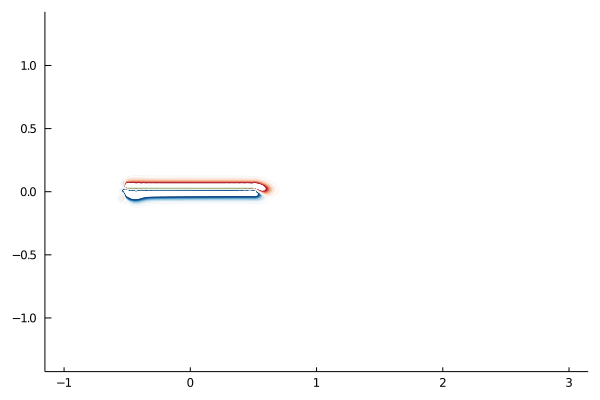

In [11]:
plot(vorticity(integrator),sys,clim=(-10,10),levels=range(-10,10,length=30),color = :RdBu)

and the forces

In [12]:
sol = integrator.sol
fx, fy = force(sol,sys,1);

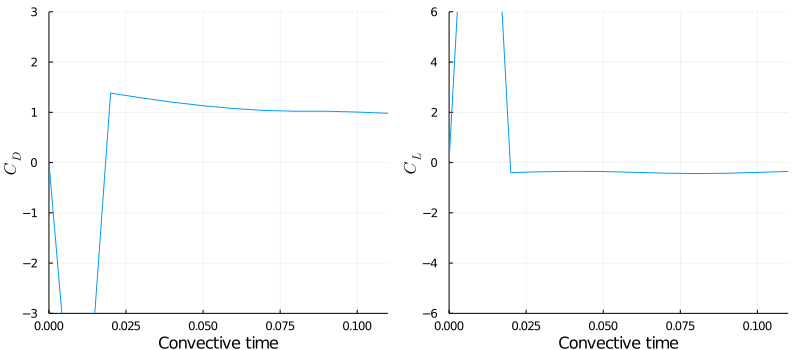

In [13]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*